<a href="https://colab.research.google.com/github/aymenchibouti/doctorat/blob/main/lstm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.utils import to_categorical




In [4]:
# Load the files
enrollment_df = pd.read_csv('enrollment_train.csv')
log_df = pd.read_csv('log_train spliting.csv')
truth_df = pd.read_csv('truth_train.csv', header=None, names=['enrollment_id', 'dropout'])

In [5]:
# Preprocess log file
log_df['time'] = pd.to_datetime(log_df['time'])
min_time_per_enrollment = log_df.groupby('enrollment_id')['time'].min().reset_index().rename(columns={'time': 'start_time'})
log_df = log_df.merge(min_time_per_enrollment, on='enrollment_id')
log_df['day'] = (log_df['time'] - log_df['start_time']).dt.days + 1
log_df.drop(columns=['start_time'], inplace=True)

In [6]:
# Create event count per day
log_df['count'] = 1
pivot_df = log_df.pivot_table(index=['enrollment_id', 'day'], columns='event', values='count', aggfunc='sum', fill_value=0).reset_index()
pivot_wide_df = pivot_df.pivot_table(index='enrollment_id', columns='day')
pivot_wide_df.columns = [f"{event}_day{day}" for (event, day) in pivot_wide_df.columns]
pivot_wide_df = pivot_wide_df.reset_index()

In [7]:
# Merge all data
merged_df = enrollment_df.merge(truth_df, on='enrollment_id', how='left')
final_df = merged_df.merge(pivot_wide_df, on='enrollment_id', how='left')

In [8]:
# Prepare X and y
X = final_df.drop(columns=['enrollment_id', 'username', 'course_id', 'dropout']).fillna(0)
y = final_df['dropout']

In [9]:
# Reshape X to 3D for LSTM (samples, timesteps, features_per_timestep)
n_features = 7  # number of event types
n_timesteps = 30  # assuming maximum 30 days


In [10]:
# Extract event names from columns
events = sorted(list(set(col.split('_')[0] for col in X.columns)))

In [11]:
events

['access', 'discussion', 'navigate', 'page', 'problem', 'video', 'wiki']

In [12]:
# Create a 3D array
X_3d = np.zeros((X.shape[0], n_timesteps, n_features))
for i, event in enumerate(events):
    for day in range(1, n_timesteps + 1):
        col_name = f"{event}_day{day}"
        if col_name in X.columns:
            X_3d[:, day - 1, i] = X[col_name].values

In [13]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_3d, y, test_size=0.2, random_state=42)

In [14]:
X_train

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [15]:
# Define LSTM model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(n_timesteps, n_features)))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
# Train model
history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.7944 - loss: 0.5939 - val_accuracy: 0.7912 - val_loss: 0.5127
Epoch 2/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - accuracy: 0.8010 - loss: 0.4991 - val_accuracy: 0.7907 - val_loss: 0.5130
Epoch 3/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 82s 25ms/step - accuracy: 0.7984 - loss: 0.5021 - val_accuracy: 0.7912 - val_loss: 0.5126
Epoch 4/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 82s 25ms/step - accuracy: 0.7977 - loss: 0.5029 - val_accuracy: 0.7910 - val_loss: 0.5127
Epoch 5/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 76s 22ms/step - accuracy: 0.8016 - loss: 0.4976 - val_accuracy: 0.7913 - val_loss: 0.5123
Epoch 6/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - accuracy: 0.8003 - loss: 0.4999 - val_accuracy: 0.7909 - val_loss: 0.5127
Epoch 7/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - accuracy: 0.8019 - loss: 0.4973 - val_accuracy: 0.7913 - val_loss: 0.5127
Epoch 8/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - accuracy: 0.7991 -

In [18]:
# Evaluate model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

754/754 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


NameError: name 'plt' is not defined

In [20]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  120  4941]
 [   30 19018]]
              precision    recall  f1-score   support

           0       0.80      0.02      0.05      5061
           1       0.79      1.00      0.88     19048

    accuracy                           0.79     24109
   macro avg       0.80      0.51      0.47     24109
weighted avg       0.80      0.79      0.71     24109



In [21]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[  120  4941]
 [   30 19018]]
              precision    recall  f1-score   support

           0       0.80      0.02      0.05      5061
           1       0.79      1.00      0.88     19048

    accuracy                           0.79     24109
   macro avg       0.80      0.51      0.47     24109
weighted avg       0.80      0.79      0.71     24109



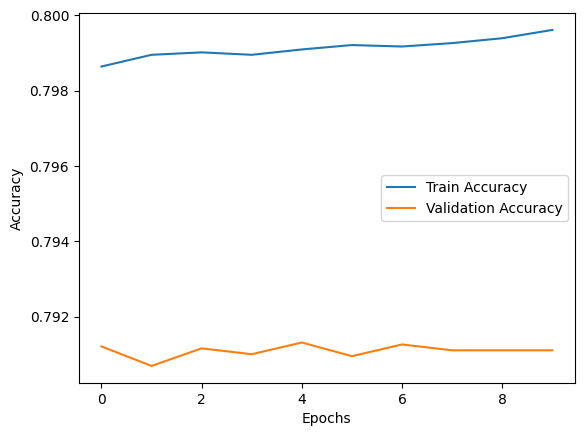

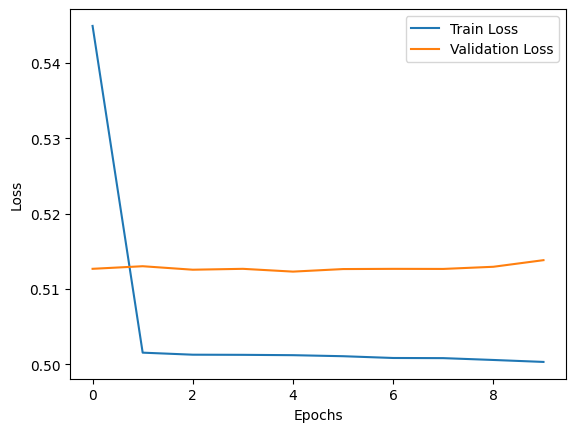

In [22]:
import matplotlib.pyplot as plt

# Assuming 'history' is the returned object from model.fit()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import roc_curve, auc ,precision_recall_curve



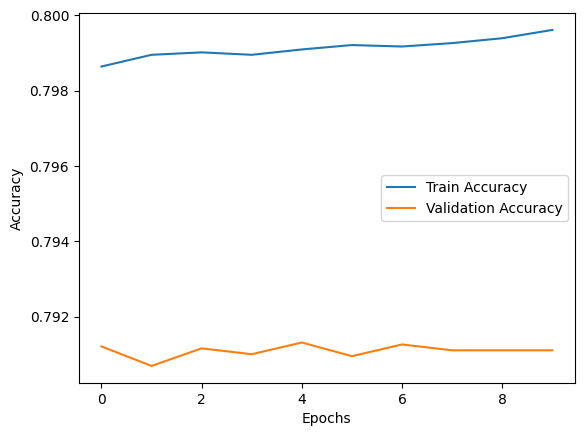

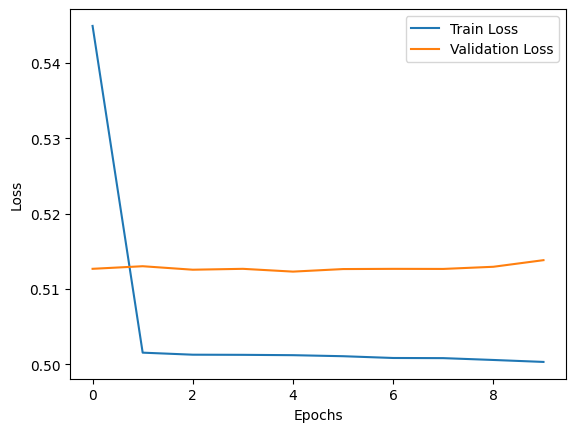

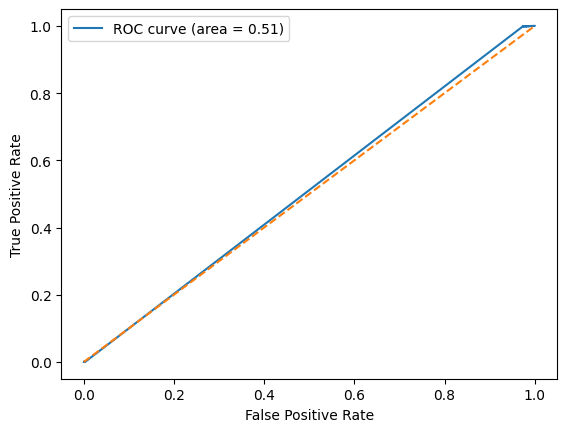

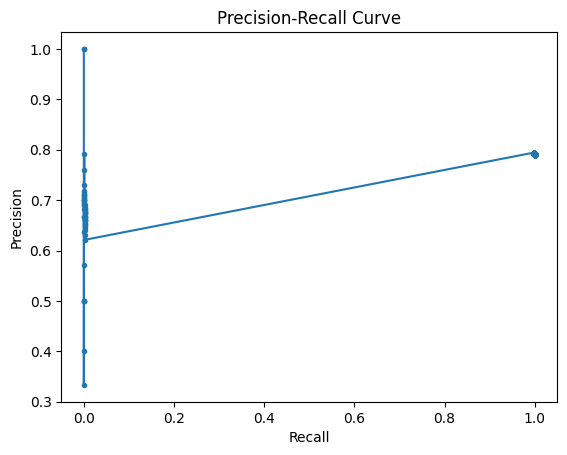

In [27]:

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
